# SpecUFEx Example: The Geysers, California

Written by Theresa Sawi and Nate Groebner

Based on the study **Machine learning reveals cyclic changes in seismic source spectra in Geysers geothermal field** by Holtzman et al., 2018. DOI 10.1126/sciadv.aao2929

This example walks through fitting a SpecUFEx model to seismograms of approximately 46,000 microearthquakes from The Geysers geothermal field in California from 2012 to 2014. Using the features extracted by SpecUFEx, k-means clustering identifies 4 clusters of earthquake patterns that are correlated to rate of water flow into the injection wells.

## Tutorial Steps

1. Read in waveforms from hdf5 file.
2. Convert waveforms to spectrograms (filtered and median normalized)
3. Run SpecUFEx on spectrograms: Nonnegative matrix factorization followed by hidden markov model
4. Do kmeans clustering on SpecUFEx fingerprints
5. Compare clusters to paper figure 3c



### Imports

In [2]:
import datetime

import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.signal as sp
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm, trange

from specufex import BayesianNonparametricNMF, BayesianHMM

## Load waveforms

The waveforms are saved to an hdf5 file. The waveforms and their IDs are loaded into numpy arrays and then stored in a pandas dataframe for easier manipulation.

In [3]:
with h5py.File("./data/geysers/all_waveforms.h5", "r") as f:
    traces = f["waveforms"][()]
    names = f["event_ids"].asstr()[()]

print(f"{len(traces)} waveforms in file")

cat = pd.DataFrame({"name":names,"trace":list(traces)})
cat.head()

45918 waveforms in file


,name,trace
0,SQK.BG.DPZ..D.2012.001.001850,"[9.366470582736789e-08, 7.655206533462191e-08,..."
1,SQK.BG.DPZ..D.2012.001.002355,"[7.404378429170258e-08, 6.503093421575965e-08,..."
2,SQK.BG.DPZ..D.2012.001.004045,"[4.2386264788434286e-08, 4.1953521799737826e-0..."
3,SQK.BG.DPZ..D.2012.001.010620,"[3.2988539628874798e-09, 8.042296180480629e-09..."
4,SQK.BG.DPZ..D.2012.001.012322,"[7.769589230310885e-08, 7.198216536693702e-08,..."


## Create spectrograms

### Set spectrogram parameters 

These parameters control spectrogram generation. Two parameters, fs (sampling rate) and len_data (number of samples of a waveform) depend on the data themselves. All waveforms must have the same number of samples. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html for more information about the parameters.

In [4]:
# waveform parameters
fs = 500 # Hz, sampling rate
len_data = 10000

# bandpass filter
fMin = 5 # Hz
fMax = 150 #Hz

# spectrogram parameters
sgramMode='magnitude'
sgramScaling='spectrum'

# frequency/time resolution
nperseg = 128
noverlap = nperseg/4
nfft = 1024



### Calculate spectrograms and convert to dB

The NMF algorithm requires that all spectrograms contain nonnegative values. The following procedure normalizes each spectrogram individually and ensures element-wise nonnegativity.

Calculate raw spectrograms using scipy:

In [5]:
fSTFT, tSTFT, STFT_raw = sp.spectrogram(
    x=np.stack(cat["trace"].values),
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    nfft=nfft,
    scaling=sgramScaling,
    axis=-1,
    mode=sgramMode
)

Quality check to see if any elements are NaN.

In [6]:
np.isnan(STFT_raw).any()

False

*Optional step*: Select a frequency band from the spectrograms

Some applications benefit from discarding low and/or high frequency data from the spectrograms, e.g. if there is significant high frequency noise. The following applies a bandpass filter to the data in the frequency domain.

In [7]:
freq_slice = np.where((fSTFT >= fMin) & (fSTFT <= fMax))
fSTFT   = fSTFT[freq_slice]
STFT_0 = STFT_raw[:,freq_slice,:].squeeze()

Next, we normalize each spectrogram by its median and convert to dB. This creates a matrix where about half of the nonzero entries are negative and half are positive. All of the negative entries are then set to zero, ensuring that the NMF algorithm has valid, nonnegative data. It also has the effect of throwing away half of the data, the half that is below the median dB value. 

In [8]:
normConstant = np.median(STFT_0, axis=(1,2))
STFT_norm = STFT_0 / normConstant[:,np.newaxis,np.newaxis]  # norm by median
del STFT_0
STFT_dB = 20*np.log10(STFT_norm, where=STFT_norm != 0) # convert to dB
del STFT_norm
STFT = np.maximum(0, STFT_dB) # make sure nonnegative
del STFT_dB

In [ ]:
cat["stft"] = list(STFT)

Another quality check.

In [10]:
bad_idx = cat["stft"][cat["stft"].apply(lambda x: np.isnan(x).any())].index
print(f"Bad spectrograms: \n{cat.loc[bad_idx].name}")
cat = cat.drop(bad_idx).sort_values("name")

Bad spectrograms: 
Series([], Name: name, dtype: object)


Plotted below is a raw spectrogram and its normalized counterpart. Notice how the overall dynamic range of spectrogram is compressed.

Text(0.5, 1.0, 'Normalized spectrogram')

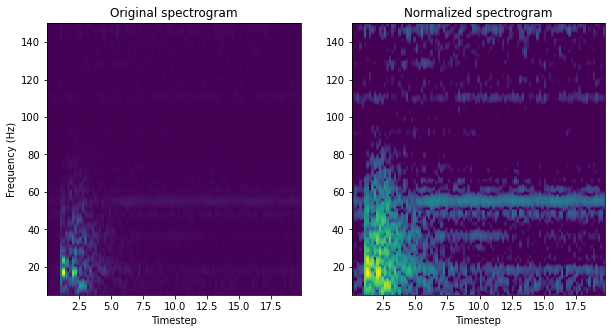

In [11]:
n_spectrogram = 0 # index of spectrogram to plot

f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].pcolormesh(tSTFT,fSTFT,STFT_raw[n_spectrogram,freq_slice,:].squeeze())
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].set_title("Original spectrogram")

ax[1].pcolormesh(tSTFT,fSTFT, STFT[n_spectrogram])
ax[1].set_xlabel("Timestep")
ax[1].set_title("Normalized spectrogram")


## Run specufex

### Fitting models and transforming data

SpecUFEx fits a group of spectrograms, where D is the number of rows (frequency bands) and M is the number of columns (timesteps) in each spectrogram. The spectrograms must be in a numpy-compatible matrix of dimension, N being the number of spectrograms in the dataset. Each spectrogram must consist of all nonnegative (>=0) entries

The two main classes in this package are `BayesianNonparametricNMF` and `BayesianHMM`. Each has fit, transform, and fit_transform methods to be consistent with the Scikit-learn API style.

### Probabilistic nonegative matrix factorization

The first step in the specufex algorithm is to decompose the set of spectrograms into a single, common "dictionary" matrix and a set of "activation matrices", one for each spectrogram. The `BayesianNonParametricNMF` class implements a probabilistic hierarchical Bayesian model for estimating this decomposition.

First instantiate the nmf model. The constructor takes a tuple with the dimensions of the spectrogram matrix.

In [11]:
nmf = BayesianNonparametricNMF(np.stack(cat["stft"].values).shape)

The model is fit in a loop. In our case, we use 100,000 batches with batch size of 1.

In [13]:
batches = 100000
batch_size = 1

t = trange(batches, desc="NMF fit progress ", leave=True)
for i in t:
    idx = np.random.randint(len(cat["stft"].values), size=batch_size)
    nmf.fit(cat["stft"].iloc[idx].values)
    t.set_postfix_str(f"Patterns: {nmf.num_pat}")

NMF fit progress : 100%|██████████| 100000/100000 [1:15:50<00:00, 21.97it/s, Patterns: 45]


The estimated dictionary matrix is plotted below.

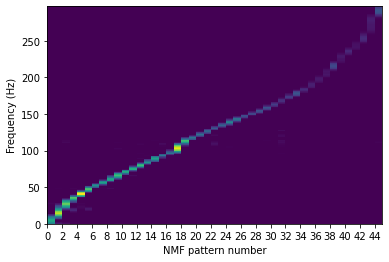

In [5]:
plt.pcolormesh(nmf.EW@np.diag(nmf.EA[0]))
plt.xlabel("NMF pattern number")
plt.xticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
plt.ylabel("Frequency (Hz)")
plt.show()

Next, the `transform` method of the` BayesianNonparametricNMF` class is used to find the activation matrices, Vs, for each spectrogram.

In [45]:
Vs = nmf.transform(cat["stft"].values)
# save Vs to an hdf5
with h5py.File("data/geysers/Vs.h5", "w") as f:
    f["Vs"] = Vs


In [12]:
with h5py.File("data/geysers/Vs.h5", "r") as f:
    Vs = f["Vs"][()]

Here is an example activation matrix, plotted with the correpsonding 

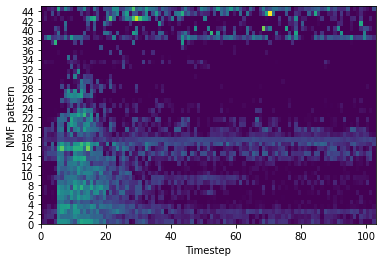

In [26]:
plt.pcolormesh(Vs[0])
plt.xlabel("Timestep")
plt.ylabel("NMF pattern")
plt.yticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
plt.show()

Remember that this is a matrix factorization problem so, the dictionary matrix times the activation matrix should produce an estimate of the original spectrogram. Below is a figure illustrating this.

### Probabilistic Hidden Markov Model

A hidden Markov model describes a system where a sequence of observations is produced by hidden, or unobservable, states. In our case, the frequency components of each timestep in a spectrogram is assumed to be emitted with a particular probability by one of the hidden states. The code fits an HMM model to the spectrograms, and for each timestep calculates the most probable hidden state that produced the frequency pattern.

The HMM model is created using the `BayesianHMM` class. Currently, in order to setup the object correctly the number of NMF patterns (num_pat) and the gain calculated by `BayesianNonparametricNMF` are passed to the constructor. Similar to the NMF calculation, the data are transformed to fingerprints with the transform function.

In [14]:
nmf = BayesianNonparametricNMF.load("data/geysers/nmf.h5")

num_states = 6
hmm = BayesianHMM(nmf.num_pat, nmf.gain, num_state=num_states, Neff=46000)

In [15]:
batches = 75000
t = trange(batches, desc="HMM fit progress ", leave=True)
for i in t:
    idx = np.random.randint(Vs.shape[0], size=1)
    hmm.fit(Vs[idx])


HMM fit progress : 100%|██████████| 75000/75000 [32:59<00:00, 37.89it/s]


The *emmission matrix* of the HMM relates the hidden state to the expected value of each frequency emitted by that state. Below is the calculated emmissions matrix for our model.

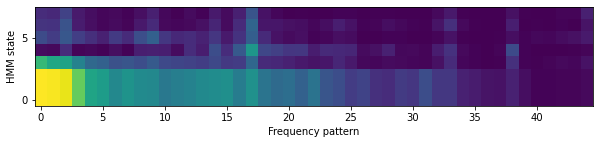

In [39]:
plt.figure(figsize=(10,5))
plt.imshow(hmm.EB, origin="lower")
plt.ylabel("HMM state")
plt.xlabel("Frequency pattern")
_=plt.yticks(range(0,num_states,5), range(0, num_states,5))

Next step is to calculate the "fingerprints", which are the final features calculated by the SpecUFEx algorithm. ?The fingerprints are a statistical representation of how likely each state transition is for each individual spectrogram.

Below, the `.transform()` method is used to calculate the fingerprints. It also returns a state transition count matrix (`As`) and the state sequence matrix (`gams`).

In [17]:
fingerprints, As, gams = hmm.transform(Vs)

Example of a fingerprint. Each entry in the matrix is the probability that, for the corresponding spectrogram, a given state transitions to another state.

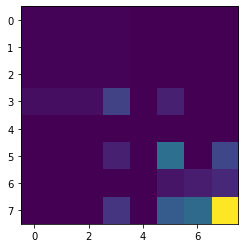

In [18]:
plt.imshow(fingerprints[0])

And this is the state transition matrix. This is the actual temporal order of probabilities that the system was in a given state when it emitted the frequencies.

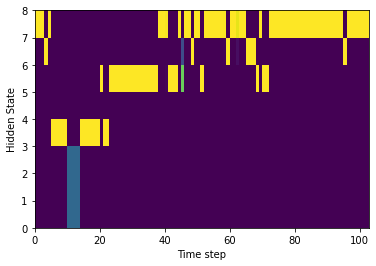

In [27]:
plt.pcolormesh(gams[0])
plt.xlabel("Time step")
plt.ylabel("Hidden State")
plt.show()

## Cluster fingerprints with Kmeans

The SpecUFEx procedure reduces a set of waveforms/spectrograms to a set of feature matrices. These features can then be used as input to a machine learning algorithm. In this example, we use the features for unsupervised clustering of similar fingerprints.


In [20]:
# convert fingerprints from 2D array to 1D array
fingerprints_ = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))

#Predicted labels
K=4 # number of clusters to fit
y_pred = KMeans(n_clusters=K, random_state=42).fit_predict(fingerprints_)

## Plot clusters over time (2012-2014)


We now compare the clusters from our fit to the results from the reference above. The following code plots the frequency of earthquakes in each cluster over time.

In [21]:
date_list = []
for name in cat["name"]:

    name = name.split('/')[-1]
    doy = int(name[19:22])
    year = int(name[14:18])

    date = pd.Timestamp(datetime.datetime(year, 1, 1)+ pd.DateOffset(doy-1))

    date_list.append(date)

df = pd.DataFrame(fingerprints_)
df['Date'] = date_list
df['Date_index'] = date_list
df['Cluster'] = y_pred
df.set_index("Date_index",inplace=True)


timeBin="M" #calculate number of events per month
barWidth=.1


barHeightsPadList = []
barHeightsPadListNorm = []


normBars = 1 # normalize colors by cluster maximum

for k in range(K):

    clus_events = df[df.Cluster == k]

    barHeights = clus_events.resample(timeBin).Cluster.count()

    ## pad bars if they start in later months or end in earlier months
    startFill = pd.date_range(start=df.index[0], end=barHeights.index[0], freq=timeBin)
    endFill = pd.date_range(start=barHeights.index[-1], end=df.index[-1], freq=timeBin)
    startFillZ = np.zeros(len(startFill),dtype='int64')
    endFillZ = np.zeros(len(endFill),dtype='int64')
    barHeightsPad = np.hstack([startFillZ,barHeights])
    barHeightsPad = np.hstack([barHeightsPad,endFillZ])
    barHeightsPadNorm = barHeightsPad / np.max(barHeightsPad)

    barHeightsPadList.append(barHeightsPad)
    barHeightsPadListNorm.append(barHeightsPadNorm)



barHeights_ar = np.array(barHeightsPadList)
barHeights_arNorm = np.array(barHeightsPadListNorm)

### Compare to Figure 3c from Holtzman et al., 2018

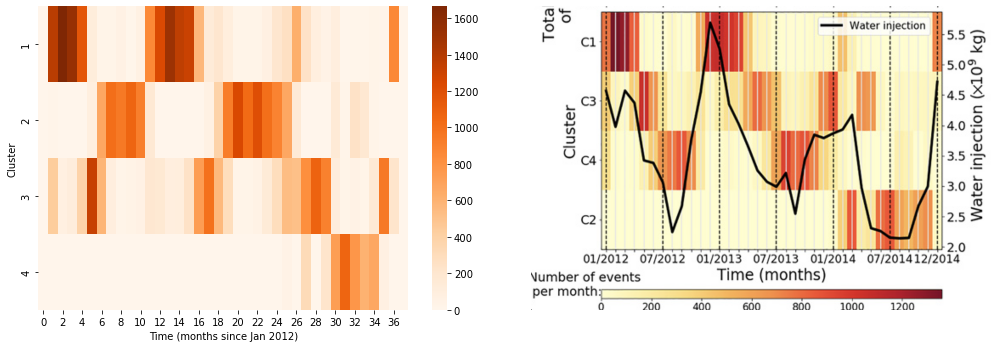

In [35]:
f, axes = plt.subplots(1,2,figsize=(14,5))
sns.heatmap(barHeights_ar,
            cmap=cm.Oranges,
            vmin = 0, #Values to anchor the colormap, otherwise they are inferred from the data and other keyword arguments.
            vmax = np.max(barHeightsPadList),
            square=False,
            ax=axes[0])

axes[0].set_ylabel('Observations \n per hour',labelpad=4)
axes[0].set_yticks([0.5,1.5,2.5,3.5])
axes[0].set_yticklabels(['1','2','3','4'])
axes[0].set_ylabel('Cluster')
axes[0].set_xlabel('Time (months since Jan 2012)')

im = plt.imread("./figures/holtzman2018_figure.png")
#plt.figure(figsize=(10,10))
axes[1].imshow(im)
axes[1].set_aspect('auto')

plt.tight_layout()
plt.axis('off');

Not too bad! Do note that the clusters are assigned numbers randomly - one cluster that we calculated may correspond to a different cluster number in the figure. Also, the algorithm is probabilistic, so the results won't be perfectly similar, and different runs with the same parameters may produce slightly different results.